In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 6, 7"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random

jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

SimulationConfig(N_particles=1000000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=0.010000000000000002, integrator=0, acceleration_scheme=1, batch_size=25000, double_map=False, external_accelerations=(0, 2))
SimulationParams(G=1, t_end=6.7070874092034565, Plummer_params=PlummerParams(a=0.1, Mtot=1.0), NFW_params=NFWParams(Mvir=10000.0, r_s=1.0, c=0.0, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=650.0, a=0.30000000000000004, b=0.03))


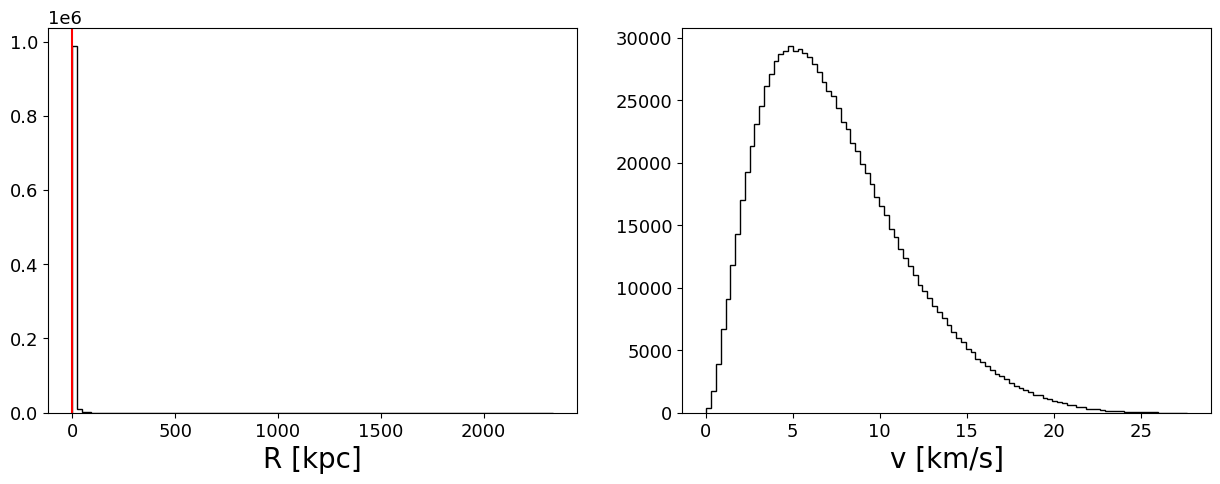

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1_000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_LAXMAP,
                          batch_size=25_000,   
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (10.0 * u.kpc).to(code_units.code_length).value,
                                               c = 0.0),
                          G=G, ) 

print(config)
print(params)
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
initial_state = construct_initial_state(positions, velocities)


#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()




In [4]:
from jax.sharding import PositionalSharding


sharding = PositionalSharding(jax.devices())
G = jax.local_device_count()

from jax_smi import initialise_tracking
initialise_tracking()
shared_positions= jax.device_put(positions, sharding.reshape(G, 1))


print(shared_positions.shape)
print(shared_positions.devices())



(1000000, 3)
{CudaDevice(id=1), CudaDevice(id=3), CudaDevice(id=0), CudaDevice(id=2)}


In [4]:
from jax.debug import visualize_array_sharding
import matplotlib as mpl

def visualize(tensor, color_map="Set3"):
    visualize_array_sharding(tensor, color_map=mpl.colormaps[color_map])
   
visualize(shared_positions)

NameError: name 'shared_positions' is not defined

In [5]:
from jax.sharding import PositionalSharding
sharding = PositionalSharding(jax.devices())
G = jax.local_device_count()

shared_initial_state = jax.device_put(initial_state, sharding.reshape(1, 1, G ).T)
print(shared_initial_state.shape)
print(shared_initial_state.devices())



(1000000, 2, 3)
{CudaDevice(id=0), CudaDevice(id=3), CudaDevice(id=1), CudaDevice(id=2)}


In [6]:
shared_dpos = shared_positions[:, None, :] - shared_positions

2025-03-10 15:45:53.484378: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below -5.09TiB (-5593049798668 bytes) by rematerialization; only reduced to 16.37TiB (18000000000024 bytes), down from 16.37TiB (18000000000024 bytes) originally
2025-03-10 15:46:03.522127: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_3_bfc) ran out of memory trying to allocate 5.46TiB (rounded to 6000000000000)requested by op 
2025-03-10 15:46:03.522233: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.46TiB (rounded to 6000000000000)requested by op 
2025-03-10 15:46:03.522300: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
2025-03-10 15:46:03.522340: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *_______________________________________________________

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6000000000000 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

In [9]:
from jax import pmap


@partial(jax.jit, static_argnames=['config'])
def single_body_acc(particle_i, particle_j, mass_i, mass_j, config, params) -> jnp.ndarray:
    """
    Compute acceleration of particle_i due to particle_j.
    
    Parameters
    ----------
    particle_i : jnp.ndarray
        Position and velocity of particle_i.
    particle_j : jnp.ndarray
        Position and velocity of particle_j.
    mass_i : float
        Mass of particle_i.
    mass_j : float
        Mass of particle_j.
    config: NamedTuple
        Configuration parameters.
    params: NamedTuple
        Simulation parameters.
    
    Returns
    -------
    Tuple
        - Acceleration: jnp.ndarray 
            Acecleration of particle_i due to particle_j.
        - Potential: jnp.ndarray
            Potential energy of particle_i due to particle_j
    """
    r_ij = particle_i - particle_j
    condtion = jnp.all(r_ij == 0.0)

    def same_position():
        return jnp.zeros(3), 0.0
    def different_position():
        r_mag = jnp.linalg.norm(r_ij)
        acc = - params.G * mass_j * (r_ij/(r_mag**2 + config.softening**2)**(3/2))
        pot = - params.G * mass_j / (r_mag**2 + config.softening**2)**(1/2)
        return acc, pot
    return jax.lax.cond(condtion, same_position, different_position)
    
    

@partial(jax.jit, static_argnames=['config', 'return_potential'])
def direct_acc(state, mass, config, params, return_potential=False):
    """
    Compute acceleration of all particles due to all other particles by vmap of the single_body_acc function.

    Parameters
    ----------
    state : jnp.ndarray
        Array of shape (N_particles, 6) representing the positions and velocities of the particles.
    mass : jnp.ndarray
        Array of shape (N_particles,) representing the masses of the particles.
    config: NamedTuple
        Configuration parameters.
    params: NamedTuple
        Simulation parameters.
    
    Returns
    -------
    Tuple
        - Acceleration: jnp.ndarray 
            Acecleration of all particles due to all other particles.
        - Potential: jnp.ndarray
            Potential energy of all particles due to all other particles
            Returned only if return_potential is True.   
    
    """

    def net_force_on_body(particle_i, mass_i):
        
        acc, potential = vmap(lambda particle_j, mass_j: single_body_acc(particle_i, particle_j, mass_i, mass_j, config, params))(state, mass)
        if return_potential:
            return jnp.sum(acc, axis=0), jnp.sum(potential, )
        else:
            return jnp.sum(acc, axis=0)

    return vmap(net_force_on_body)(state, mass)


acc  = direct_acc(shared_positions, mass, config, params)

2025-03-10 15:47:12.131181: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 99.60GiB (106942601323 bytes) by rematerialization; only reduced to 10.91TiB (12000006000024 bytes), down from 10.91TiB (12000014000024 bytes) originally
2025-03-10 15:47:22.309343: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_3_bfc) ran out of memory trying to allocate 10.91TiB (rounded to 12000000000256)requested by op 
2025-03-10 15:47:22.309495: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *___________________________________________________________________________________________________
2025-03-10 15:47:22.309564: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.91TiB (rounded to 12000000000256)requested by op 
E0310 15:47:22.309530  759015 pjrt_stream_executor_client.cc:3026] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 12000000000144 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).